# ノイズモデルと生成 (Noise Models & Generation)

このチュートリアルでは、`gwexpy.noise` サブパッケージを使用して、様々なノイズモデル（ASD: 振幅スペクトル密度）を取得し、それに基づいた時系列ノイズデータを生成する方法を学びます。

### 学ぶこと
1. **検出器ノイズモデル**: LVK (LIGO, Virgo, aLIGO) などの設計感度を取得 (`pygwinc` 連携)
2. **環境ノイズモデル**: 地震・インフラサウンドの標準モデルを取得 (`ObsPy` 連携)
3. **パラメトリックノイズ**: 白色雑音、ピンクノイズなどのASD生成
4. **時系列生成**: ASD モデルから着色ノイズ (Colored Noise) の時系列データを生成

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.noise.asd import from_obspy, from_pygwinc
from gwexpy.noise.colored import pink_noise, white_noise
from gwexpy.noise.wave import from_asd
from gwexpy.plot import Plot

plt.rcParams['figure.figsize'] = (10, 6)

## 1. 検出器ノイズモデル (pygwinc 連携)

`from_pygwinc` 関数を使用すると、主要な重力波検出器の設計感度を `FrequencySeries` オブジェクトとして簡単に取得できます。
※ 事前に `pygwinc` のインストールが必要です。

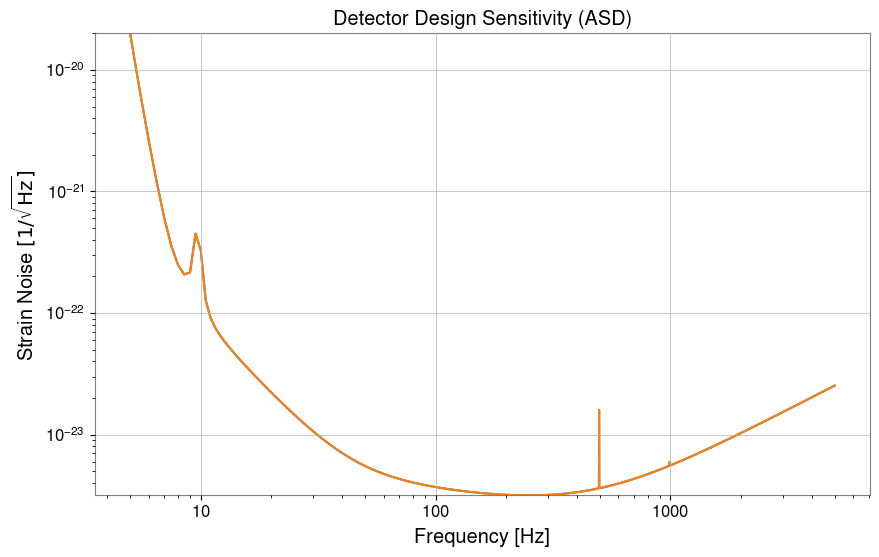

In [2]:
try:
    # aLIGO の設計感度 (Strain)
    # quantity='strain' を指定して単位を統一します
    asd_aligo = from_pygwinc('aLIGO', fmin=5, fmax=5000, df=0.5, quantity='strain')

    # aLIGO の設計感度
    asd_kagra = from_pygwinc('aLIGO', fmin=5, fmax=5000, df=0.5, quantity='strain')

    # プロット
    plot = Plot(asd_aligo, asd_kagra, xscale='log', yscale='log')
    plot.gca().set_title("Detector Design Sensitivity (ASD)")
    plot.gca().set_ylabel(r"Strain Noise $[1/\sqrt{\mathrm{Hz}}]$ ")
    plot.show()

except ImportError:
    print("pygwinc not installed. Skipping this section.")

## 2. 環境ノイズモデル (ObsPy 連携)

地震学で標準的な地球ノイズモデル（NHNM/NLNM）や、インフラサウンドのノイズモデルも取得可能です。

- `NHNM`: New High Noise Model (Peterson, 1993)
- `NLNM`: New Low Noise Model
- `IDCH`/`IDCL`: IDC Infrasound High/Low Noise Models

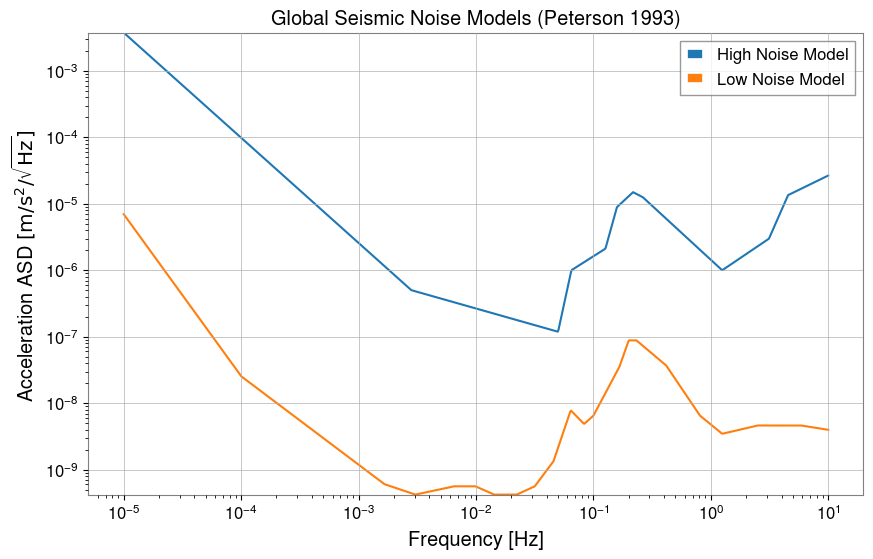

In [3]:
# 地震ノイズモデル (加速度 ASD)
# quantity='acceleration' を指定して加速度単位で取得
nhnm = from_obspy('NHNM', fmin=0.01, fmax=100, df=0.01, quantity='acceleration')
nlnm = from_obspy('NLNM', fmin=0.01, fmax=100, df=0.01, quantity='acceleration')

# プロット
plot = Plot(nhnm, nlnm, xscale='log', yscale='log',
            label=['High Noise Model', 'Low Noise Model'])
plot.gca().set_title("Global Seismic Noise Models (Peterson 1993)")
plot.gca().set_ylabel(r"Acceleration ASD $[\mathrm{m}/\mathrm{s}^2/\sqrt{\mathrm{Hz}}]$ ")
plot.show()

## 3. パラメトリックノイズモデル

`gwexpy.noise.colored` モジュールを使えば、シンプルなべき乗則に従うノイズ ASD を作成できます。

- White Noise: $f^0$
- Pink Noise: $f^{-1/2}$ (PSD $\propto 1/f$)
- Red Noise: $f^{-1}$ (PSD $\propto 1/f^2$)

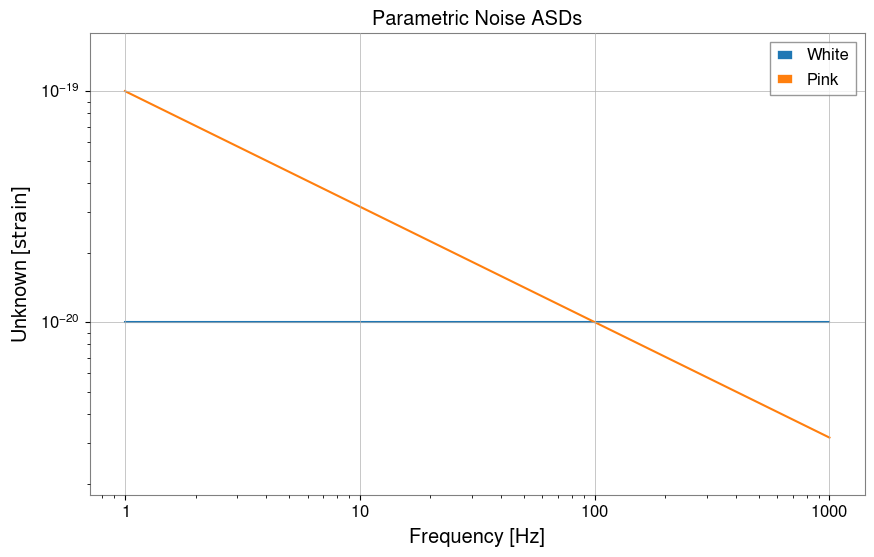

In [4]:
freqs = np.linspace(1, 1000, 1000)

# 白色雑音 ASD (一定値 1e-20)
asd_white = white_noise(amplitude=1e-20, frequencies=freqs, unit='strain')

# ピンクノイズ ASD (1/f ノイズ)
asd_pink = pink_noise(amplitude=1e-20, f_ref=100, frequencies=freqs, unit='strain')

Plot(asd_white, asd_pink, xscale='log', yscale='log',
     label=['White', 'Pink'], title="Parametric Noise ASDs").show()

## 4. 時系列ノイズの生成 (Time-Series Generation)

`gwexpy.noise.wave` モジュールを使用すると、定義した ASD モデルに従う時系列データを生成（シミュレーション）できます。

### 例: aLIGO 設計感度に従うノイズの生成
先ほど取得した `asd_aligo` をもとに、10秒間の着色ノイズを生成し、そのスペクトルが元のモデルと一致するか確認します。

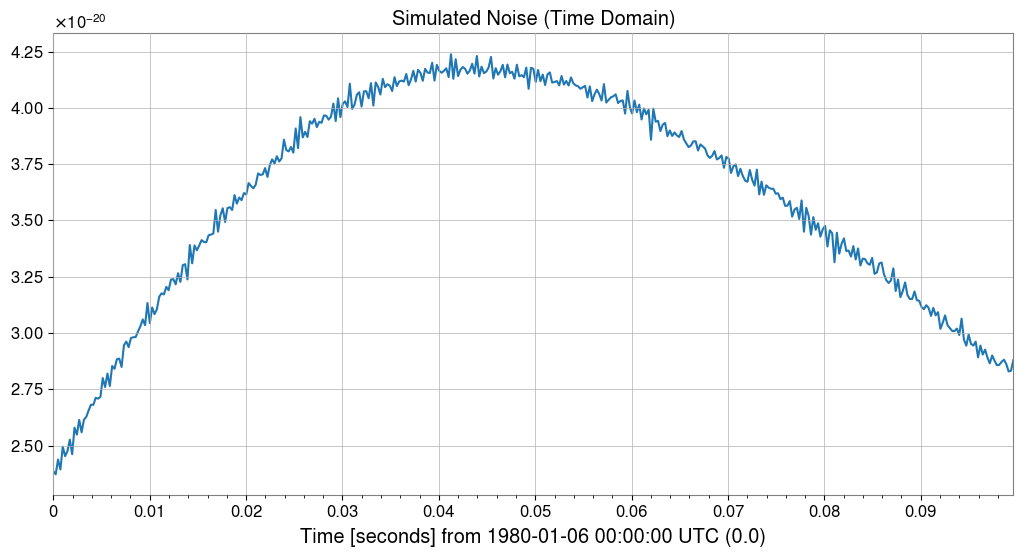

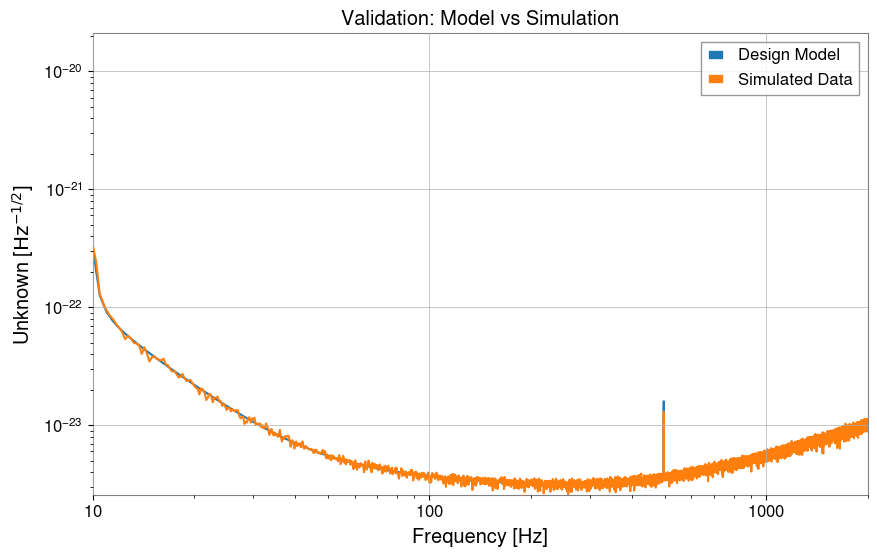

In [5]:
try:
    # aLIGO ASD から時系列データを生成
    # duration: 秒, sample_rate: Hz
    noise_ts = from_asd(asd_aligo, duration=32, sample_rate=4096)
    noise_ts.name = "Simulated aLIGO Noise"

    # 時系列データのプロット (最初の0.1秒)
    noise_ts.crop(0, 0.1).plot(title="Simulated Noise (Time Domain)").show()

    # 検証: 生成データの ASD を計算してモデルと比較
    # fftlength を長めにとって周波数分解能を確保
    asd_measured = noise_ts.asd(fftlength=4, method='welch', window='hann')

    plot = Plot(asd_aligo, asd_measured,
                xscale='log', yscale='log',
                label=['Design Model', 'Simulated Data'])
    plot.gca().set_title("Validation: Model vs Simulation")
    plot.gca().set_xlim(10, 2000)
    plot.show()

except NameError:
    print("asd_aligo が定義されていません (pygwinc がない場合など)")
except ImportError:
    pass

## まとめ

- `gwexpy.noise` は、外部ライブラリ (`pygwinc`, `obspy`) と連携して標準的なノイズモデルを簡単に利用できます。
- `from_asd` 関数を使うことで、任意の周波数特性を持つノイズデータをシミュレーション生成可能です。
- これにより、実際の検出器データを模擬した信号解析のテストや開発が可能になります。